In [ ]:
!pip install kaggle
from google.colab import files 
#files.open('/content/drive/MyDrive/Colab Notebooks/json kaggle')
files.upload() #download and upload json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d merahul28/covid19-vaccine-related-tweets

In [ ]:
!kaggle datasets download -d ritesh2000/covid19-vaccine-tweets

In [ ]:
from zipfile import ZipFile
file_name= "covid19-vaccine-tweets.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
from zipfile import ZipFile
file_name= "covid19-vaccine-related-tweets.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
#import library

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder   ###########
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.manifold import TSNE ######
from sklearn.feature_extraction.text import TfidfVectorizer #############

from keras.preprocessing.text import Tokenizer         #######
from keras.preprocessing.sequence import pad_sequences #######
from keras.models import Sequential
from keras.layers import Dropout , Conv1D ,MaxPool1D,Activation , Dense , Flatten , Embedding , LSTM ####

from keras import utils
from keras.callbacks import ReduceLROnPlateau , EarlyStopping


#nltk

import nltk
from nltk.corpus import stopwords ########
from nltk.stem import SnowballStemmer ############


#word to vec
import gensim

import re #####
import os
from collections import Counter #######
import logging ###
import time
import pickle ######
import itertools ######


from textblob import TextBlob # TextBlob - Python library for processing textual data
import random
np.random.seed(0)


# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [ ]:
#load data 
df1 = pd.read_csv('/content/file.csv')
df2=pd.read_csv('/content/COVID-Vaccine Related tweets NOV1 to DEC16.csv')

In [ ]:
display(df2)

In [ ]:
df2.columns

In [ ]:
df2.head()

In [ ]:
from pandas import datetime 

df2['date'] = pd.to_datetime(df2['date'])
df2['Month'] = df2['date'].dt.month
df2['Month-str-full'] = df2['date'].dt.strftime('%B')


In [ ]:
df2['Month-str-full'].value_counts()

In [ ]:

print(min(df2['date']))
print(max(df2['date']))

In [ ]:
print(min(df1['date']))
print(max(df1['date']))

In [ ]:
df2 = df2[df2['language']=='en']
df2 = df2[['date' , 'tweet']]

In [ ]:
df1 = df1[df1['language']=='en']
df1 = df1[['date' , 'tweet']]

In [ ]:
df1.head()

In [ ]:
df2.head()

In [ ]:

df2['tweet'].isna().sum()

In [ ]:
df2['date'].isna().sum()

In [ ]:
df1['tweet'].isna().sum()

In [ ]:
df1['date'].isna().sum()

In [ ]:
print(df1.shape)
print(df2.shape)

In [ ]:
data = pd.concat([df1,df2],ignore_index=True)
data.head()

In [ ]:
data.shape

In [ ]:
data.drop_duplicates(subset=['tweet'])
data.shape

In [ ]:
data['process_tweet'] = data['tweet'].copy()
data.head()

# Preprocessing the Tweet


In [ ]:
def clean_data(txt):
  txt = txt.lower()  # lowercase
  txt = re.sub(r'@[A-Za-z0-9_]+' , '' , txt)   #remove mentions
  txt = re.sub(r'#' , '' , txt) #remove hashtags
  txt = re.sub(r'RT : ','' , txt) # remove retweets
  txt = re.sub(r'https?:\/\/[A-Za-z0-9\./\/]+' , '' , txt) #removes url
  txt = re.sub('\[.*?\]' , '' , txt) #remove square brackets
  txt = re.sub(r'[^\w\s]' , '' , txt) #remove puntuations
  txt = re.sub('\w*\d\w*' , '' ,txt) #removes words containig numbers
  txt = re.sub('\n' , '' ,txt) #remove new lines
 

  return txt


In [ ]:
data['process_tweet'] = data['process_tweet'].apply(clean_data)
data['process_tweet']

In [ ]:
nltk.download('stopwords')

In [ ]:
#removig stop words

stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(txt):
  rmv_stpwords = [i for i in txt.split() if i not in stopwords]
  rmv_stpwords_join = ' '.join(rmv_stpwords)
  return rmv_stpwords_join

 

In [ ]:
data['process_tweet'] = data['process_tweet'].apply(remove_stopwords)

data.head()#after removing stopwords

In [ ]:
from nltk.stem import PorterStemmer
st = PorterStemmer()

In [ ]:
def stemming(txt):
  txt =[st.stem(word) for word in txt.split()]
  txt_join = ' '.join(txt)
  return txt_join

#Stemming refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach.

In [ ]:
data['process_tweet'] = data['process_tweet'].apply(stemming)
data.head()

In [ ]:
!pip install vaderSentiment

In [ ]:

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
data['Polarity_Vader'] = data['process_tweet'].apply(lambda txt: sid.polarity_scores(txt)['compound'])
data.head()

# Labeling

5 labels: 
strongly positive,
positive,
nuteral,
negative,
strongly negetative.


In [ ]:

def get_text_polarity(txt):
  return TextBlob(txt).sentiment.polarity

In [ ]:
#add 2 columns(subjectivity and polarity) to the data

#data['Subjectivity'] = data['process_tweet'].apply(get_text_subjectivity)

data['Polarity_textblob'] = data['process_tweet'].apply(get_text_polarity)

In [ ]:

#Labeling
def get_text_analysis(i):
  if (i<-0.5):
    return 'Strongly Negative'
  elif ((i<0 ) and (i >= -0.5)):
    return 'Negative'
  elif (i == 0):
    return 'Neutral'
  elif (i>0 and i<=0.5):
    return 'Positive'
  else:
    return 'Strongly Positive'



In [ ]:
data['Sentiment_TB'] = data['Polarity_textblob'].apply(get_text_analysis)
data['Sentiment_VADER'] = data['Polarity_Vader'].apply(get_text_analysis)

In [ ]:
data.head()

In [ ]:
possible_labels = data.Sentiment_TB.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels): 
#The enumerate() function takes a collection (e.g. a tuple) and returns it as an enumerate object.
    label_dict[possible_label] = index

data['label_TB'] = data.Sentiment_TB.replace(label_dict)



In [ ]:
#possible_labels = data.Sentiment_VADER.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels): 
#The enumerate() function takes a collection (e.g. a tuple) and returns it as an enumerate object.
    label_dict[possible_label] = index

data['label_VD'] = data.Sentiment_VADER.replace(label_dict)


In [ ]:
possible_labels

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace=True, drop=True)
data.head()

In [ ]:
df=data[['date','Sentiment_TB' ,'label_TB','Sentiment_VADER' ,'label_VD']]
data = data[['process_tweet','Sentiment_TB' ,'label_TB','Sentiment_VADER' ,'label_VD']]
data.head()



,process_tweet,Sentiment_TB,label_TB,Sentiment_VADER,label_VD
0,pfizer expect file eua coronaviru vaccin soon ...,Neutral,2,Positive,0
1,year covid vaccin normal thing understand relu...,Positive,0,Neutral,2
2,well said unfortun diseas u refer limit peopl ...,Strongly Negative,4,Negative,3
3,look forward scalp covidvaccin paperwork park lot,Neutral,2,Neutral,2
4,hope covid vaccin mutat give everyon superpow,Neutral,2,Positive,0


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
df.head()

,date,Sentiment_TB,label_TB,Sentiment_VADER,label_VD
0,2020-10-12 00:00:00,Neutral,2,Strongly Negative,4
1,2020-06-12 00:00:00,Positive,0,Neutral,2
2,2020-11-14 00:00:00,Neutral,2,Negative,3
3,2020-01-12 00:00:00,Neutral,2,Neutral,2
4,2020-11-19 00:00:00,Neutral,2,Strongly Negative,4


In [ ]:
df["date"] = pd.to_datetime(df['date'])

df = df.sort_values(by='date')
display(df)

,date,Sentiment_TB,label_TB,Sentiment_VADER,label_VD
455142,2020-01-11,Neutral,2,Neutral,2
340542,2020-01-11,Negative,3,Positive,0
6520,2020-01-11,Neutral,2,Neutral,2
443864,2020-01-11,Neutral,2,Neutral,2
734485,2020-01-11,Positive,0,Positive,0
...,...,...,...,...,...
587739,2020-12-16,Neutral,2,Neutral,2
8002,2020-12-16,Positive,0,Neutral,2
354511,2020-12-16,Positive,0,Strongly Positive,1
300333,2020-12-16,Negative,3,Neutral,2


In [ ]:
df['mnth_yr'] = df['date'].apply(lambda x: x.strftime('%B-%Y')) 
df.head()

,date,Sentiment_TB,label_TB,Sentiment_VADER,label_VD,mnth_yr
455142,2020-01-11,Neutral,2,Neutral,2,January-2020
340542,2020-01-11,Negative,3,Positive,0,January-2020
6520,2020-01-11,Neutral,2,Neutral,2,January-2020
443864,2020-01-11,Neutral,2,Neutral,2,January-2020
734485,2020-01-11,Positive,0,Positive,0,January-2020


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
df.head()

,date,Sentiment_TB,label_TB,Sentiment_VADER,label_VD,mnth_yr
0,2020-09-09,Neutral,2,Neutral,2,September-2020
1,2020-08-28,Positive,0,Positive,0,August-2020
2,2020-11-24,Neutral,2,Negative,3,November-2020
3,2020-11-18,Neutral,2,Negative,3,November-2020
4,2020-12-13,Positive,0,Strongly Positive,1,December-2020


In [ ]:
df['mnth_yr'].unique()

array(['September-2020', 'August-2020', 'November-2020', 'December-2020',
       'April-2020', 'January-2020', 'October-2020', 'July-2020',
       'February-2020', 'June-2020', 'March-2020', 'May-2020'],
      dtype=object)

In [ ]:
df['Year'] = pd.DatetimeIndex(df['date']).year  
df['Year'].unique()

array([2020])

In [ ]:
from pandas import datetime 

df['date'] = pd.to_datetime(df['date'])
df['Month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['Month-str-full'] = df['date'].dt.strftime('%B')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
possible_months = df['Month-str-full'].unique()
print(possible_labels)
print(possible_months)

['Positive' 'Strongly Positive' 'Neutral' 'Negative' 'Strongly Negative']
['September' 'August' 'November' 'December' 'April' 'January' 'October'
 'July' 'February' 'June' 'March' 'May']


In [ ]:
df.head()

,date,Sentiment_TB,label_TB,Sentiment_VADER,label_VD,mnth_yr,Year,Month,year,Month-str-full
0,2020-09-09,Neutral,2,Neutral,2,September-2020,2020,9,2020,September
1,2020-08-28,Positive,0,Positive,0,August-2020,2020,8,2020,August
2,2020-11-24,Neutral,2,Negative,3,November-2020,2020,11,2020,November
3,2020-11-18,Neutral,2,Negative,3,November-2020,2020,11,2020,November
4,2020-12-13,Positive,0,Strongly Positive,1,December-2020,2020,12,2020,December


In [ ]:
df['Month-str-full'].value_counts()

November     194118
December     109639
September    106590
August        77587
October       76572
July          50109
April         33751
May           33423
March         29425
February      28447
June          25018
January        9367
Name: Month-str-full, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


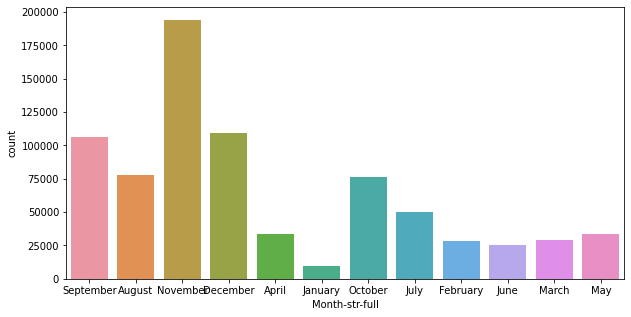

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,5))

sns.countplot(df['Month-str-full']);

In [ ]:
df_new = data.copy()

#df_new.rename(columns={'Sentiment' : 'Data'} , inplace= True)

df_new.head()

,process_tweet,Sentiment_TB,label_TB,Sentiment_VADER,label_VD
0,pfizer expect file eua coronaviru vaccin soon ...,Neutral,2,Positive,0
1,year covid vaccin normal thing understand relu...,Positive,0,Neutral,2
2,well said unfortun diseas u refer limit peopl ...,Strongly Negative,4,Negative,3
3,look forward scalp covidvaccin paperwork park lot,Neutral,2,Neutral,2
4,hope covid vaccin mutat give everyon superpow,Neutral,2,Positive,0


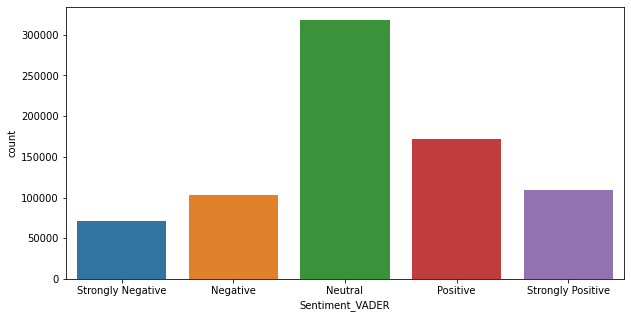

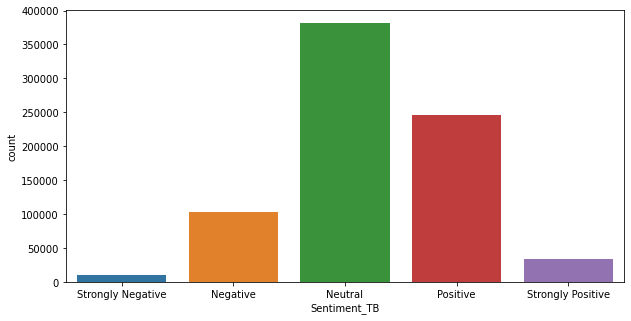

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment_VADER', data=df_new, order=['Strongly Negative' ,'Negative' , 'Neutral' , 'Positive' , 'Strongly Positive']);




plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment_TB', data=df_new, order=['Strongly Negative' ,'Negative' , 'Neutral' , 'Positive' , 'Strongly Positive']);

Text(0, 0.5, 'Num of Tweet ')

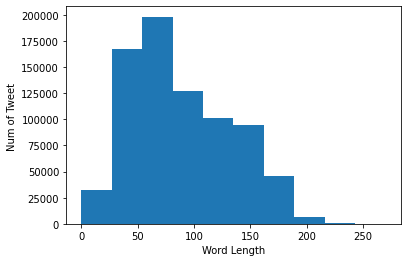

In [ ]:
data['process_tweet'].str.len().plot.hist()
plt.xlabel('Word Length')
plt.ylabel('Num of Tweet ')

In [ ]:
#import library for deep learning
from sklearn.model_selection import train_test_split


from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [ ]:

#for deep learning we need to only 2 colums(sentiment and process tweet)
data = data[['Sentiment_TB','process_tweet' ]]
data.head()

,Sentiment_TB,process_tweet
0,Neutral,pfizer expect file eua coronaviru vaccin soon ...
1,Positive,year covid vaccin normal thing understand relu...
2,Strongly Negative,well said unfortun diseas u refer limit peopl ...
3,Neutral,look forward scalp covidvaccin paperwork park lot
4,Neutral,hope covid vaccin mutat give everyon superpow


In [ ]:
data1 = data.copy()      #########    for experiment ,max_words

In [ ]:
data1.head()

,Sentiment_TB,process_tweet
0,Neutral,pfizer expect file eua coronaviru vaccin soon ...
1,Positive,year covid vaccin normal thing understand relu...
2,Strongly Negative,well said unfortun diseas u refer limit peopl ...
3,Neutral,look forward scalp covidvaccin paperwork park lot
4,Neutral,hope covid vaccin mutat give everyon superpow


In [ ]:
data1 = data1.reset_index(drop=True) #for removing missig index 

#see previous index 3 is replaced by new index 2
data1.head() 

,Sentiment_TB,process_tweet
0,Neutral,pfizer expect file eua coronaviru vaccin soon ...
1,Positive,year covid vaccin normal thing understand relu...
2,Strongly Negative,well said unfortun diseas u refer limit peopl ...
3,Neutral,look forward scalp covidvaccin paperwork park lot
4,Neutral,hope covid vaccin mutat give everyon superpow


In [ ]:
uniqueWords = list(set(" ".join(data['process_tweet']).lower().split(" ")))
count = len(uniqueWords)
print(count)

165769


In [ ]:
#tokenization
tokenizer = Tokenizer(num_words=count, split=' ')
#num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.


tokenizer.fit_on_texts(data1['process_tweet'].values)

X = tokenizer.texts_to_sequences(data1['process_tweet'].values)

In [ ]:
X[:3] #before padding

[[6,
  143,
  1213,
  1121,
  3,
  1,
  126,
  1121,
  146,
  334,
  467,
  1121,
  69,
  376,
  226,
  1,
  1252,
  1731,
  6,
  674],
 [30, 2, 1, 273, 116, 417, 3282, 294, 362, 40],
 [93,
  54,
  1739,
  320,
  319,
  1542,
  873,
  7,
  1128,
  1882,
  43555,
  892,
  18,
  428,
  1403,
  10,
  72,
  68,
  42,
  2,
  1,
  1751,
  18,
  62752,
  123,
  82,
  1335,
  1138]]

In [ ]:
#padding to make all text vector to same length

X = pad_sequences(X)

X[:3] #after padding

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     6,   143,  1213,  1121,     3,
            1,   126,  1121,   146,   334,   467,  1121,    69,   376,
          226,     1,  1252,  1731,     6,   674],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    30,     2,     1,   273,
          116,   417,  3282,   294,   362,    40],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

In [ ]:
X.shape[1]

51

In [ ]:

model= Sequential()
model.add(Embedding(count, 256 , input_length=X.shape[1]))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Dropout(0.3))
model.add(LSTM(128 , return_sequences=True , dropout=0.3 , recurrent_dropout=0.3))
model.add(LSTM(128,dropout=0.3 , recurrent_dropout=0.3))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 256)           42436864  
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 200)           153800    
_________________________________________________________________
dropout (Dropout)            (None, 49, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 49, 128)           168448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 256)           42436864  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 200)           153800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 49, 128)           135680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_5 (Dense)              (None, 50)               

In [ ]:
#one hot encoding

y = pd.get_dummies(data1['Sentiment_TB']).values

[print(data1['Sentiment_TB'][i] ,y[i]) for i in range(0,5)]

Neutral [0 1 0 0 0]
Positive [0 0 1 0 0]
Strongly Negative [0 0 0 1 0]
Neutral [0 1 0 0 0]
Neutral [0 1 0 0 0]


[None, None, None, None, None]

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state = 22)

In [ ]:
#trannig model
batch_size = 128
epochs = 5

In [ ]:
history = model.fit(x_train , y_train ,
          epochs = epochs,
          batch_size = batch_size,
          validation_split=0.1,
          verbose=1)

Epoch 1/5
4354/4354 [==============================] - 2390s 537ms/step - loss: 0.2747 - accuracy: 0.9015 - val_loss: 0.0454 - val_accuracy: 0.9842
Epoch 2/5
4354/4354 [==============================] - 2314s 532ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.0283 - val_accuracy: 0.9910
Epoch 3/5
4354/4354 [==============================] - 2330s 535ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0238 - val_accuracy: 0.9924
Epoch 4/5
4354/4354 [==============================] - 2322s 533ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0237 - val_accuracy: 0.9922
Epoch 5/5
4354/4354 [==============================] - 2309s 530ms/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.0275 - val_accuracy: 0.9911


In [ ]:
predictions = model.predict(x_test)
print('done')

done


In [ ]:
print(predictions)

[[2.61491641e-06 1.57661743e-05 1.48867539e-05 1.33335625e-05
  9.99953389e-01]
 [1.54602822e-06 9.99987960e-01 6.20877881e-06 1.94729500e-06
  2.40846202e-06]
 [1.67237079e-06 9.99986887e-01 6.71163707e-06 2.08095571e-06
  2.57920510e-06]
 ...
 [3.17011626e-07 5.59002547e-06 4.39371797e-05 2.10828875e-06
  9.99948025e-01]
 [6.22240714e-06 6.61630984e-05 9.99926209e-01 2.53945046e-07
  1.16846024e-06]
 [9.99678493e-01 1.47811224e-04 4.71953499e-05 1.25661536e-04
  1.01249395e-06]]


In [ ]:
%%time
score = model.evaluate(x_test, y_test , batch_size = batch_size)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1210/1210 [==============================] - 37s 31ms/step - loss: 0.0289 - accuracy: 0.9909

ACCURACY: 0.9909307956695557
LOSS: 0.028910571709275246
CPU times: user 37.3 s, sys: 826 ms, total: 38.1 s
Wall time: 37.2 s


In [ ]:
[print(data1['process_tweet'][i], predictions[i], y_test[i] ) for i in range(1, 3)
]

year covid vaccin normal thing understand reluct deal real time [1.5460282e-06 9.9998796e-01 6.2087788e-06 1.9472950e-06 2.4084620e-06] [0 1 0 0 0]
well said unfortun diseas u refer limit peopl specif color peabrain idiot like guy everywher say let start test covid vaccin moron like himmayb that way contribut societi [1.6723708e-06 9.9998689e-01 6.7116371e-06 2.0809557e-06 2.5792051e-06] [0 1 0 0 0]


[None, None]

In [ ]:

pred1 = np.argmax(predictions , axis=1)
pred1[:10]

array([4, 1, 1, 2, 0, 1, 1, 1, 2, 1])

In [ ]:
y_test = np.argmax(y_test , axis=1)


In [ ]:


print(y_train.shape)
print(x_train.shape)  #160824 trainnig data

(619236, 5)
(619236, 51)


In [ ]:
print(y_test.shape)
print(x_test.shape)     #40206 test data

(154810,)
(154810, 51)


In [ ]:
print(confusion_matrix(y_test , pred1 ,normalize=None))

[[20319    64   100    30     0]
 [  159 76242    77     1     1]
 [  376   227 48223     0   191]
 [   65     2     0  1929     0]
 [    0     0   111     0  6693]]


In [ ]:
print(confusion_matrix(y_test , pred1))

[[20319    64   100    30     0]
 [  159 76242    77     1     1]
 [  376   227 48223     0   191]
 [   65     2     0  1929     0]
 [    0     0   111     0  6693]]


In [ ]:
print(classification_report(y_test , pred1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     20513
           1       1.00      1.00      1.00     76480
           2       0.99      0.98      0.99     49017
           3       0.98      0.97      0.98      1996
           4       0.97      0.98      0.98      6804

    accuracy                           0.99    154810
   macro avg       0.98      0.98      0.98    154810
weighted avg       0.99      0.99      0.99    154810



In [ ]:
accuracy_score(y_test , pred1)

0.9909308184225826

In [ ]:
print(confusion_matrix(y_test , pred1))

[[20319    64   100    30     0]
 [  159 76242    77     1     1]
 [  376   227 48223     0   191]
 [   65     2     0  1929     0]
 [    0     0   111     0  6693]]


In [ ]:
#Mean Squared Error
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred1)

0.02916478263678057

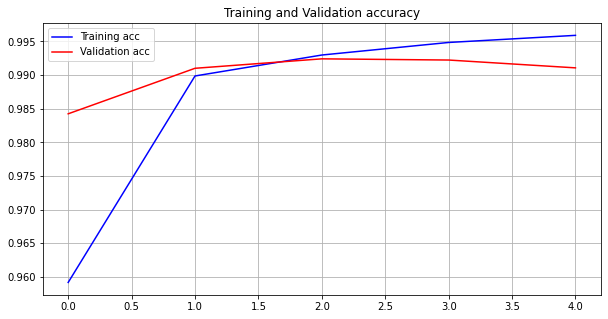

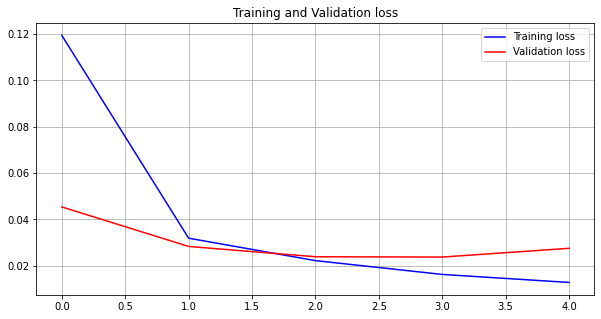

In [ ]:
plt.figure(figsize=(10,5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.grid(True)
 
plt.figure(figsize=(10,5))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid(True)
plt.legend()

plt.show()


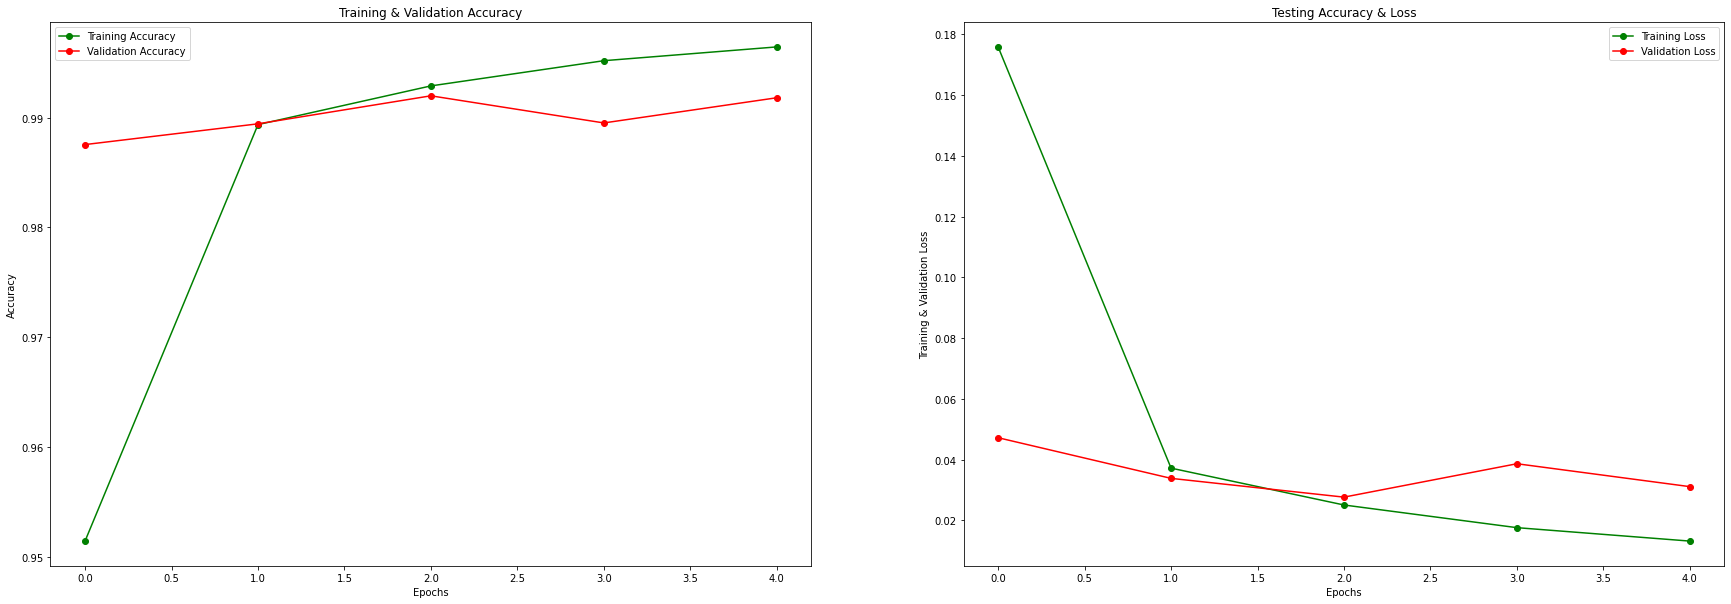

In [ ]:

epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(30,10)


ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')

ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

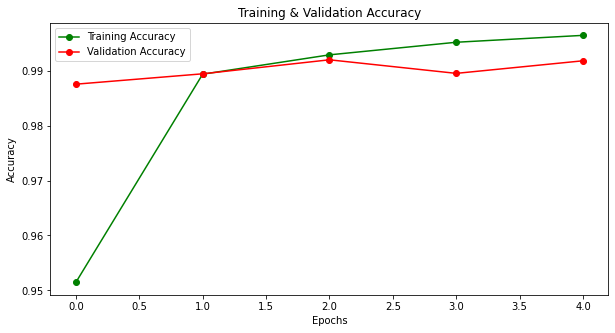

In [ ]:

epochs = [i for i in range(5)]

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))


plt.plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

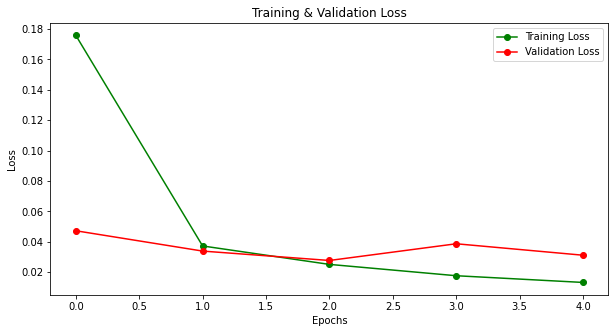

In [ ]:
epochs = [i for i in range(5)]

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))


plt.plot(epochs , train_loss , 'go-' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
plt.title('Training & Validation Loss')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()